In [36]:
import pandas as pd
import numpy as np
import google.generativeai as genai
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
import os
from dotenv import load_dotenv

# Configuration for Gemini
# Replace 'YOUR_API_KEY_HERE' with your actual Google AI Studio API Key
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=api_key)
model_gemini = genai.GenerativeModel('gemini-2.5-flash')

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder

class DecisionTreeBaseline:
    def __init__(self, file_path):
        self.file_path = file_path
        self.model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
        self.metrics = {}
        self.train_metrics = {}
        self.feature_importance = None
        self.X_train_cols = None # Crucial for Task 1 visualization

    def train_and_evaluate(self):
        # 1. Load Data
        df = pd.read_csv(self.file_path)
        
        # 2. DROP LEAKAGE & UNNECESSARY COLS
        # 'risk_category' is dropped because it's a proxy for the target (leakage)
        # 'customer_financial_statement' is raw text
        # 'sentiment' is kept as it's a feature, but you could drop it if performance is poor
        cols_to_drop = ['default_risk', 'sentiment', 'customer_financial_statement', 'customer_id', 'risk_category']
        
        X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
        y = df['default_risk']
    
        # 3. SPLIT FIRST (Crucial for preventing procedural leakage)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        # 4. DATA CLEANING (Using Train-Set Statistics only)
        # Fill missing numeric values with the median of the training set
        numeric_cols = X_train.select_dtypes(include=['number']).columns
        for col in numeric_cols:
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
    
        # 5. CATEGORICAL ENCODING
        categorical_cols = X_train.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            le = LabelEncoder()
            X_train[col] = le.fit_transform(X_train[col].astype(str))
            # Handle unknown categories in test set by mapping them to -1
            X_test[col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    
        self.X_train_cols = X_train.columns
        self.X_train, self.y_train = X_train, y_train
        
        # 6. CROSS-VALIDATION (Task 3 Requirement)
        scoring = ['accuracy', 'f1', 'roc_auc']
        cv_results = cross_validate(self.model, X_train, y_train, cv=5, scoring=scoring)
    
        # 7. TRAIN FINAL MODEL
        self.model.fit(X_train, y_train)
    
        # 8. PREDICTIONS & METRICS
        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)[:, 1]
    
        self.metrics = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1_Score": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_prob),
            "CV_Mean_Accuracy": cv_results['test_accuracy'].mean(),
            "CV_Mean_F1": cv_results['test_f1'].mean(),
            "CV_Mean_ROC_AUC": cv_results['test_roc_auc'].mean()
        }
    
        # Overfitting check
        self.train_metrics = {"Accuracy": accuracy_score(y_train, self.model.predict(X_train))}
    
        # 9. FEATURE IMPORTANCE
        self.feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': self.model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
    
        return X_test, y_test, y_pred

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix: Baseline Decision Tree")
        plt.show()

    def get_llm_interpretation(self):
        prompt = f"""
        You are a Senior Risk Data Scientist. Analyze this BASELINE Decision Tree model:
        Performance Metrics: {self.metrics}
        Top 5 Features: {self.feature_importance.head(5).to_string(index=False)}

        Please provide:
        1. A technical evaluation of the Accuracy vs ROC-AUC.
        2. Business Insight: How can the bank use the top feature to reduce losses?
        3. A brief summary for the 'Results' section of a formal report.
        """
        response = model_gemini.generate_content(prompt)
        return response.text

In [38]:
df = pd.read_csv("./data/credit_risk_dataset.csv")
df.columns

Index(['age', 'monthly_income', 'credit_utilization_ratio', 'loan_amount',
       'loan_duration_months', 'num_late_payments', 'existing_loans_count',
       'account_tenure_years', 'employment_type', 'education_level',
       'marital_status', 'region', 'customer_financial_statement', 'sentiment',
       'financial_stress_level', 'risk_category', 'default_risk'],
      dtype='object')

--- BASELINE DECISION TREE METRICS ---
Accuracy: 0.9567
F1_Score: 0.9401
ROC_AUC: 0.9807
CV_Mean_Accuracy: 0.9408
CV_Mean_F1: 0.9206
CV_Mean_ROC_AUC: 0.9693


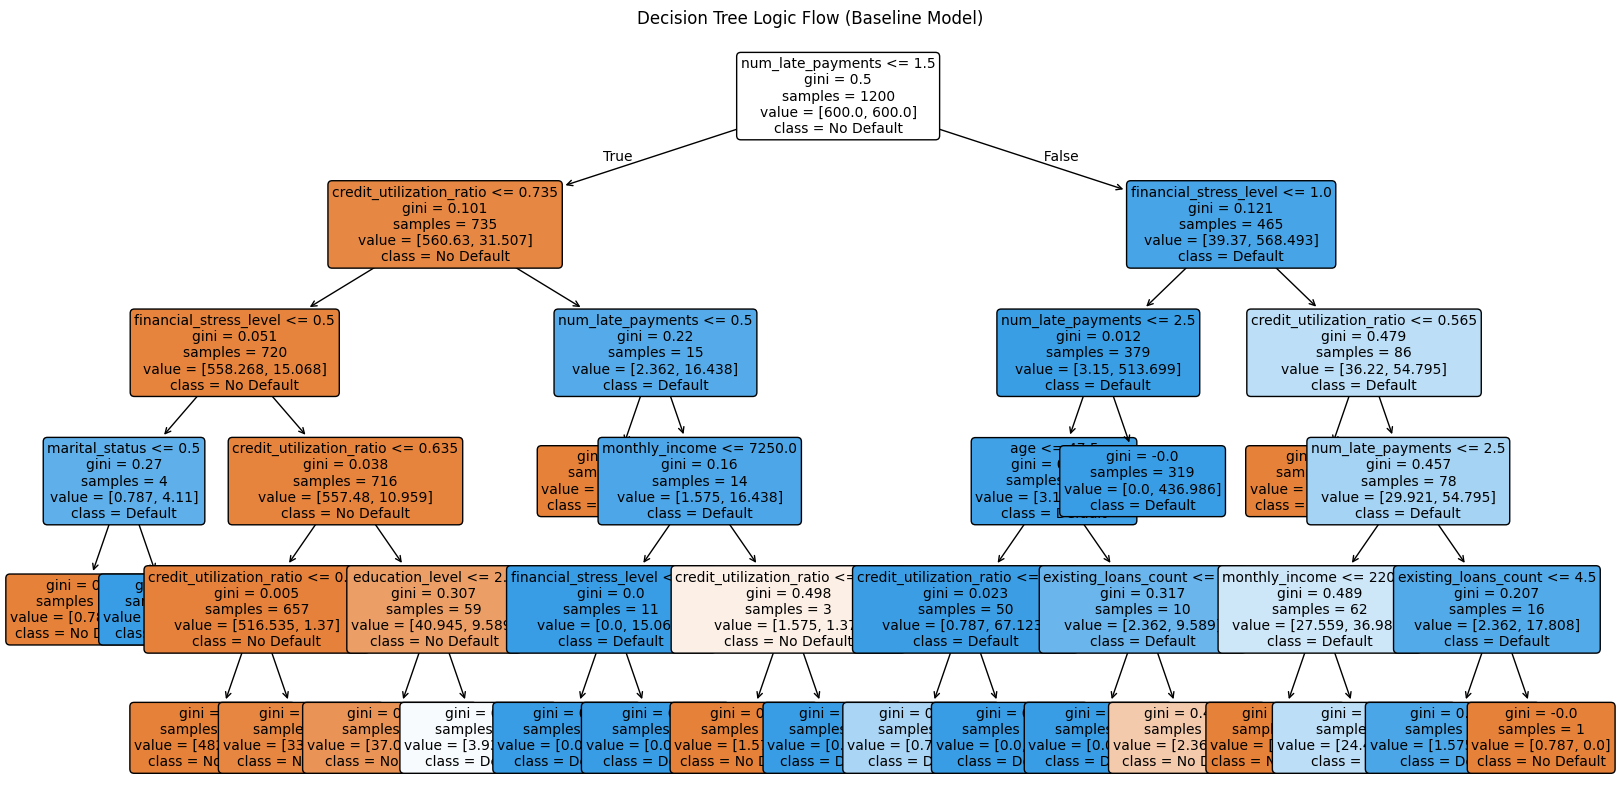


--- GENAI BASELINE INTERPRETATION ---
As a Senior Risk Data Scientist, here's my analysis of the BASELINE Decision Tree model:

---

### **1. Technical Evaluation: Accuracy vs. ROC-AUC**

The model exhibits strong performance across all reported metrics, indicating a robust baseline for credit risk assessment.

*   **Overall Performance:** The cross-validated (CV) metrics (Mean Accuracy: 0.9408, Mean F1: 0.9206, Mean ROC-AUC: 0.9693) are slightly lower than the single train/test split results, which is expected and healthy. This confirms the model's ability to generalize well to unseen data and avoids significant overfitting to a single partition.

*   **Accuracy (0.9408 CV Mean):** A high accuracy suggests that the model correctly classifies a large proportion of both good and bad credit risks. While excellent, accuracy alone can sometimes be misleading in imbalanced datasets (where defaults might be rare). However, given the strong F1-Score, this suggests the balance between Precisi

In [39]:
# 1. Initialize and Run Baseline
dt_baseline = DecisionTreeBaseline("./data/credit_risk_dataset.csv")
X_test, y_test, y_pred = dt_baseline.train_and_evaluate()

# 2. Print Metrics
print("--- BASELINE DECISION TREE METRICS ---")
for k, v in dt_baseline.metrics.items():
    print(f"{k}: {v:.4f}")

# 3. Visualize the Decision Tree (Visual Evidence for Report)
plt.figure(figsize=(20, 10))
plot_tree(dt_baseline.model,
          feature_names=dt_baseline.X_train_cols,
          class_names=['No Default', 'Default'],
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Logic Flow (Baseline Model)")
plt.show()

# 4. Get GenAI Interpretation (Task 3)
print("\n--- GENAI BASELINE INTERPRETATION ---")
baseline_insights = dt_baseline.get_llm_interpretation()
print(baseline_insights)

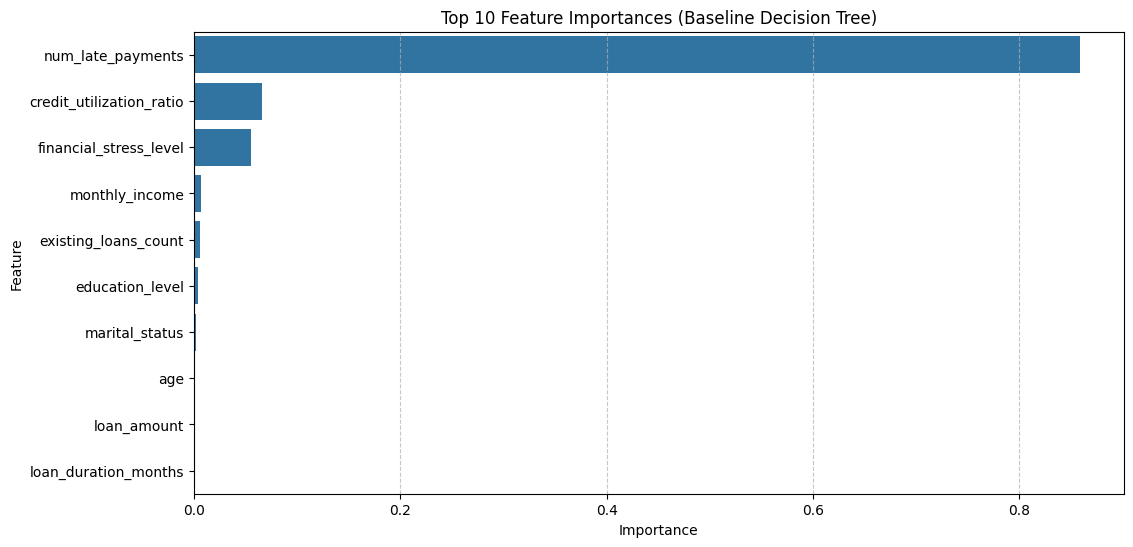

C:\Users\User\AppData\Local\Temp\ipykernel_21592\2113292384.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')


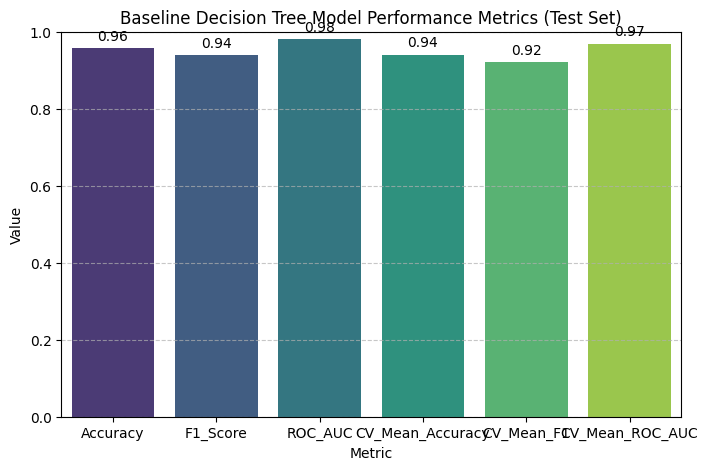

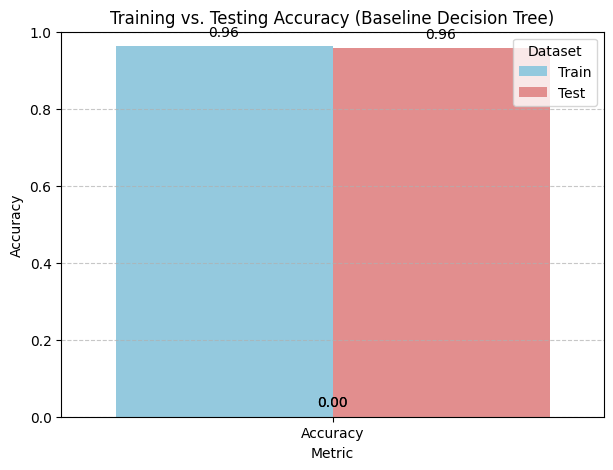

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=dt_baseline.feature_importance.head(10))
plt.title('Top 10 Feature Importances (Baseline Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plot Test Metrics
metrics_df = pd.DataFrame(dt_baseline.metrics.items(), columns=['Metric', 'Value'])
plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')
plt.title('Baseline Decision Tree Model Performance Metrics (Test Set)')
plt.ylim(0, 1.0) # Metrics like accuracy, F1, ROC_AUC are typically between 0 and 1
for index, row in metrics_df.iterrows():
    plt.text(row.name, row.Value + 0.02, f'{row.Value:.2f}', color='black', ha="center")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Training vs. Testing Accuracy
accuracy_data = {
    'Metric': ['Accuracy'],
    'Train': [dt_baseline.train_metrics['Accuracy']],
    'Test': [dt_baseline.metrics['Accuracy']]
}
accuracy_df = pd.DataFrame(accuracy_data).melt(id_vars='Metric', var_name='Dataset', value_name='Accuracy')

plt.figure(figsize=(7, 5))
sns.barplot(x='Metric', y='Accuracy', hue='Dataset', data=accuracy_df, palette={'Train': 'skyblue', 'Test': 'lightcoral'})
plt.title('Training vs. Testing Accuracy (Baseline Decision Tree)')
plt.ylim(0, 1.0)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

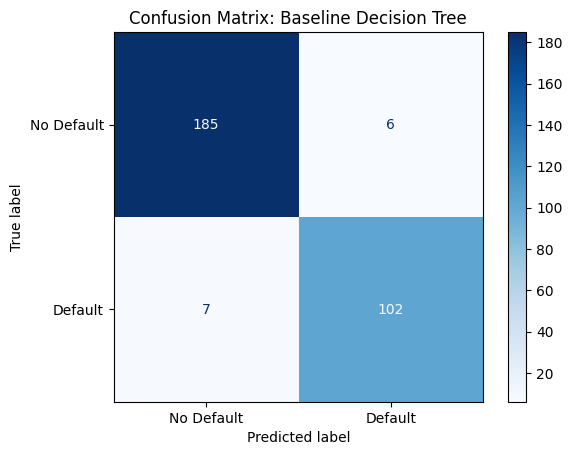

In [41]:
# After running train_and_evaluate
dt_baseline.plot_confusion_matrix(X_test, y_test)